In [40]:
from capstone_data_eng import *
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint



In [52]:
import pandas as pd
import sklearn
import statsmodels

print('pandas: ',pd.__version__)
print('sklearn: ',sklearn.__version__)
print('statsmodels: ',statsmodels.__version__)

pandas:  0.24.2
sklearn:  0.21.2
statsmodels:  0.9.0


In [2]:
out, profile_all, portfolio, offers_all, transactions_all, transactions_during_offer, transactions_outside_offer = load_data_cv(
        person_split=None, rename_offers=True, time_split_min=None, time_split_max=None,
        add_transactions=False, skip_overlap=False, skip_add_purchases=False, calc_net_offer_time=True,
        assign_to='ignore', location='local')

c:\X\ML\Starbucks_capstone\capstone_data_eng.py:741: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  profile_all = load_profile(location=location)


offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64
er,ec,ev
(76277, 3) (33579, 4) (57725, 3)
er  (76277, 6)
persons with no offers received in timeframe:  6
transactions_during_offer.shape: (122652, 7)
(76277, 27)
add_stats_by_person:
(76277, 38)
(76277, 44)
(76277, 50)
(76277, 51)
(76277, 60)


# Utility functions

In [70]:
def percentage_true_by(df,by,column):
    # returns the percentage of true value in dataframe df grouped by by
    
    ratio_true_false=df.groupby(by=by)[column].value_counts(normalize=True)
    percentage_true=ratio_true_false.loc[ratio_true_false.index.get_level_values(column)==True,:]
    percentage_true=100.*percentage_true.droplevel(level=column)
    return(percentage_true)
    
def grouped_mean(df,group_list,binary_variable ):

    counts=df.groupby(by=group_list)[binary_variable].value_counts()

    out=counts.loc[counts.index.get_level_values(binary_variable)==True,:]
    out=out.droplevel(level=binary_variable).to_frame()

    out['total']=df.groupby(by=group_list)[binary_variable].count()
#     out=out.reset_index()
    mean_df=100.*out[binary_variable]/out['total']
    mean_df=mean_df.rename('percentage_'+binary_variable)

    return(mean_df.reset_index())
    
def grouped_proportions(df,group_list,binary_variable,alpha=0.05,method='normal'):

    counts=df.groupby(by=group_list)[binary_variable].value_counts()

    out=counts.loc[counts.index.get_level_values(binary_variable)==True,:]
    out=out.droplevel(level=binary_variable).to_frame()

    out['total']=df.groupby(by=group_list)[binary_variable].count()
    out=out.reset_index()

    lb,ub= proportion_confint(out[binary_variable],out['total'],alpha=alpha, method=method)
    out['lb']=lb
    out['ub']=ub
    out['mean']=out[binary_variable]/out['total']

    return(out)

def plot_proportions( df,col_groups, col_x ,alpha=0.2):
    values=np.unique(df[col_groups])
    colors=sns.color_palette('muted',values.shape[0])
    
    n=0
    for value in values:

        cc=df.loc[df[col_groups]==value]

        xm=np.array(cc[col_x].values)

        alpha_line=np.max((alpha+.6,1))
        plt.plot(xm,100.*cc['lb'].values,alpha=alpha_line,color=colors[n],label=value)
        plt.plot(xm,100.*cc['ub'].values,alpha=alpha_line,color=colors[n])
        plt.fill_between(xm,100.*cc['lb'],100.*cc['ub'],alpha=alpha,color=colors[n])
        
        n+=1
    plt.xlabel(col_x)

# 2) EDA: Customers

In [4]:
profile_all.head()

,age,became_member_on,gender,person,income,joined_year,joined_month,joined_week,gender_num,user_time
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,6,-1,529
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,28,0,376
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,28,-1,14
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,19,0,443
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,31,-1,356


## 2.1) Demographics

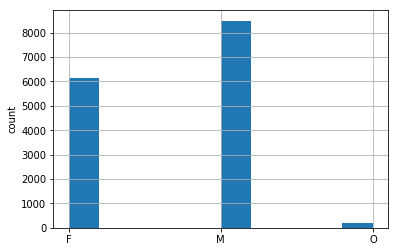

In [45]:
profile_all['gender'].dropna().hist()
plt.ylabel('count');

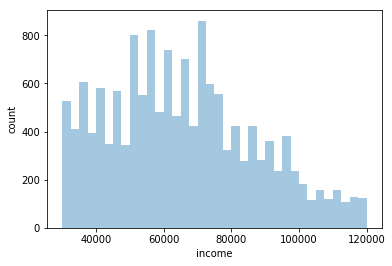

In [43]:
sns.distplot(profile_all['income'].dropna(),kde=False);
plt.ylabel('count');

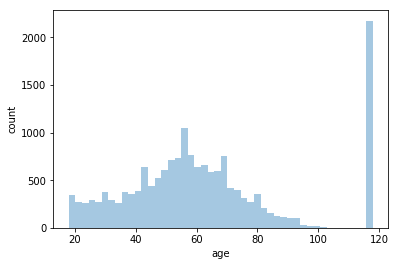

In [5]:
sns.distplot(profile_all['age'],kde=False);
plt.ylabel('count');

As discussed in the write-up, these users that don't like to provide birth, gender and income information are classified in a different group.

In [17]:
profile_all['group118']=profile_all['age']>110

In [9]:
profile_all.loc[profile_all.group118,'income'].dropna()

Series([], Name: income, dtype: float64)

In [10]:
profile_all.loc[profile_all.group118,'gender'].dropna()

Series([], Name: gender, dtype: object)

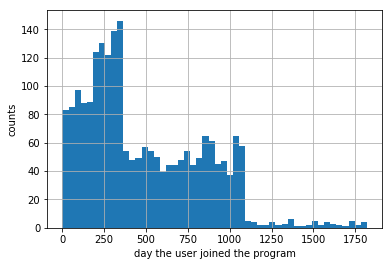

In [20]:
profile_all.loc[profile_all.group118,'user_time'].hist(bins=50);
plt.ylabel('counts');
plt.xlabel('day the user joined the program');


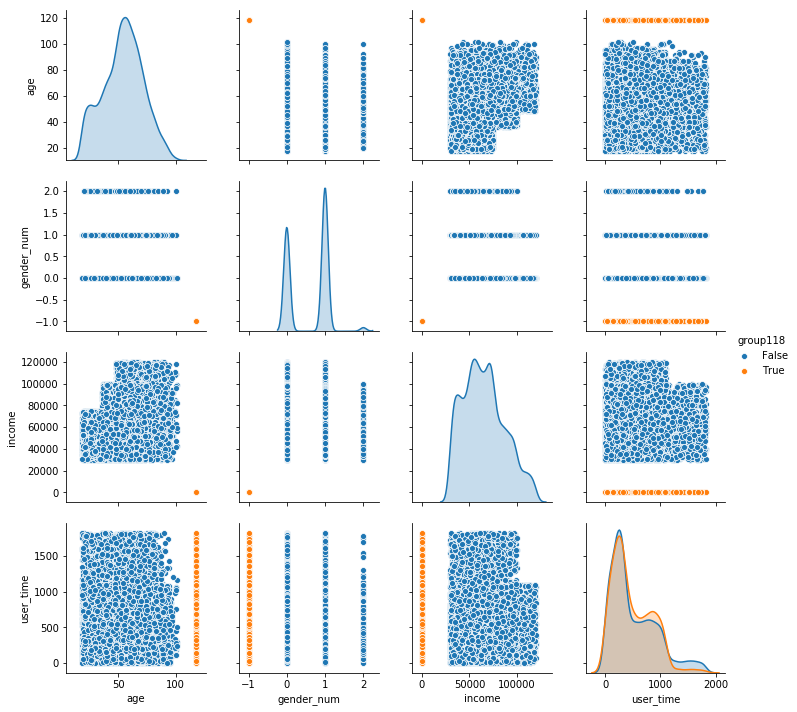

In [31]:
sns.pairplot(profile_all.fillna(-1),vars=['age','gender_num','income','user_time'],hue='group118');

## 2.2 Customer Response

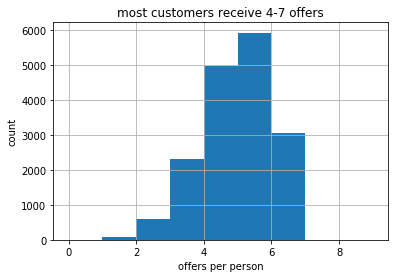

In [34]:
pout=out.groupby(by='person')['offer'].agg('count')
pout.hist(bins=range(0,10))
plt.xlabel('offers per person')
plt.ylabel('count');
plt.title('most customers receive 4-7 offers');

### 2.2.1) Completion ratio

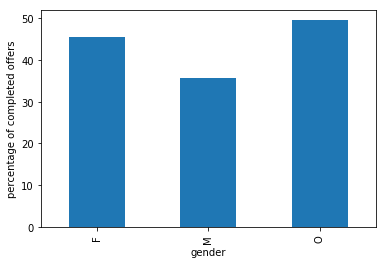

In [38]:
percentage_true_by(out,'gender','completed').plot.bar();
plt.ylabel('percentage of completed offers');

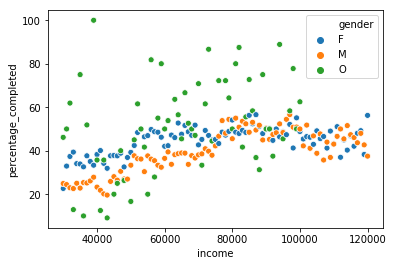

In [75]:
po=grouped_mean(out,['income','gender'],'completed')
sns.scatterplot(x='income',y='percentage_completed', hue='gender',data=po);

#### Binning to reduce noise

In [76]:
out['binned_income'] = pd.cut(out['income'],bins= np.arange(0,14)*1e4,labels=np.arange(0,13)*10)
out['binned_age'] = pd.cut(out['age'],bins= np.arange(0,120,10) ,labels=np.arange(0,120,10)[:-1])

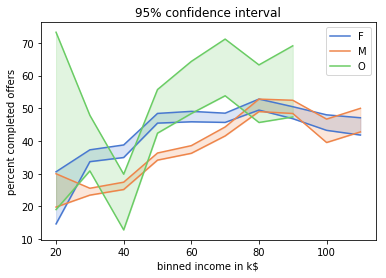

In [80]:
cmp=grouped_proportions(out,['binned_income','gender'],'completed')
plot_proportions( cmp,'gender', 'binned_income' ,alpha=0.2);
plt.legend();
plt.xlabel('binned income in k$');
plt.ylabel('percent completed offers');
plt.title('95% confidence interval');

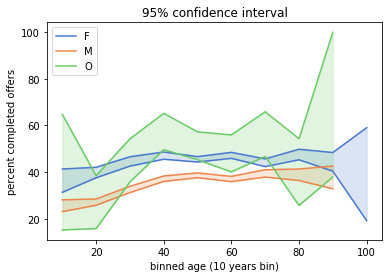

In [81]:
cmp=grouped_proportions(out,['binned_age','gender'],'completed')
plot_proportions( cmp,'gender', 'binned_age' ,alpha=0.2);
plt.legend();
plt.xlabel('binned age (10 years bin)');
plt.ylabel('percent completed offers');
plt.title('95% confidence interval');

### 2.2.2) Total dollar purchases in during offers

Text(0,0.5,'mean $ purchases during offer')

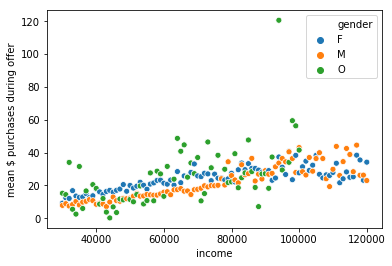

In [82]:
po=(out.groupby(by=['income','gender'])['Tpay_offer'].mean()).reset_index() 

sns.scatterplot(x='income',y='Tpay_offer', hue='gender',data=po)
plt.ylabel('mean $ purchases during offer');

Again binning enables to estimate the 95% confidence interval for the average total amount during an offer.
We plot only the M,F classes because of the dispersion of the O class.

C:\anaconda3\envs\ds\lib\site-packages\seaborn\algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
C:\anaconda3\envs\ds\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


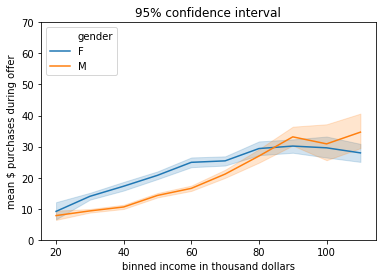

In [83]:
sns.lineplot(x='binned_income',y='Tpay_offer', hue='gender',data=out.loc[out.gender!='O'],ci=95)
plt.xlabel('binned income in thousand dollars')

plt.ylabel('mean $ purchases during offer')
plt.ylim(0,70)
plt.title('95% confidence interval')
plt.legend(loc=2);

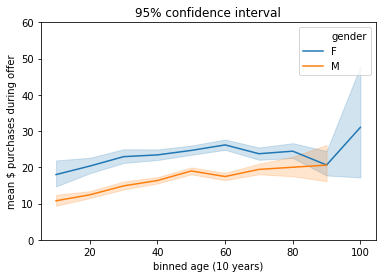

In [85]:
sns.lineplot(x='binned_age',y='Tpay_offer', hue='gender',data=out.loc[out.gender!='O'],ci=95)
plt.ylabel('mean $ purchases during offer')
plt.xlabel('binned age (10 years)')

plt.ylim(0,60)
plt.title('95% confidence interval');

The aggregated results are interesting because they show some variation depending on gender and income. We should however remember that this is the average across different offers with different characteristics

### 2.2.3) Response outside of offers

The response outside of the offer is also interesting. To make the comparison fair we look at the average purchase per hour.



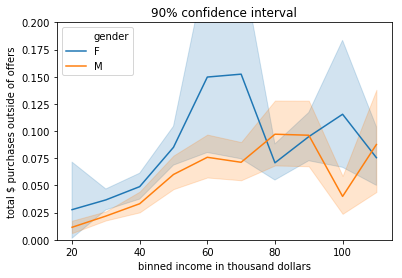

In [96]:
pout=out.groupby(by='person')['Tpay_offers_tot','Trewards_tot','Tpay_out','Avg_D_nOS','income','gender_num','age','Avg_pay_outside','Avg_pay_offers'].agg('mean')
pout['gender']='M'
pout.loc[pout.gender_num==0,'gender']='F'
pout.loc[pout.gender_num==2,'gender']='O'

pout['binned_income'] = pd.cut(pout['income'],bins= np.arange(0,14)*1e4,labels=np.arange(0,13)*10)
pout['binned_age'] = pd.cut(pout['age'],bins= np.arange(0,120,10) ,labels=np.arange(0,120,10)[:-1])

sns.lineplot(x='binned_income',y='Avg_pay_outside', hue='gender',data=pout.loc[pout.gender!='O'],ci=90,hue_order=['F','M'])
plt.ylabel('total $ purchases outside of offers')
plt.xlabel('binned income in thousand dollars')

plt.ylim(0,.2)
plt.title('90% confidence interval')
plt.legend(loc=2);

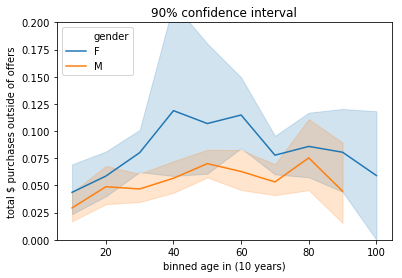

In [99]:
sns.lineplot(x='binned_age',y='Avg_pay_outside', hue='gender',data=pout.loc[pout.gender!='O'],ci=90,hue_order=['F','M'])
plt.ylabel('total $ purchases outside of offers')
plt.xlabel('binned age in (10 years)')

plt.ylim(0,.2)
plt.title('90% confidence interval')
plt.legend(loc=2);

We can compare this with the average purchase per hour during the offers.

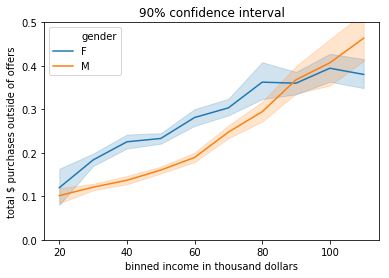

In [98]:
sns.lineplot(x='binned_income',y='Avg_pay_offers', hue='gender',data=pout.loc[pout.gender!='O'],ci=90,hue_order=['F','M'])
plt.ylabel('total $ purchases outside of offers')
plt.xlabel('binned income in thousand dollars')

plt.ylim(0,.5)
plt.title('90% confidence interval')
plt.legend(loc=2);

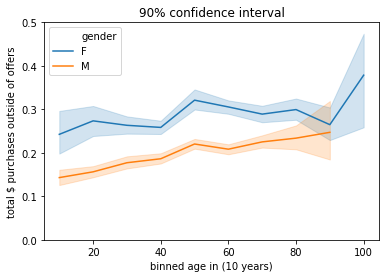

In [101]:
sns.lineplot(x='binned_age',y='Avg_pay_offers', hue='gender',data=pout.loc[pout.gender!='O'],ci=90,hue_order=['F','M'])
plt.ylabel('total $ purchases outside of offers')
plt.xlabel('binned age in (10 years)')

plt.ylim(0,.5)
plt.title('90% confidence interval')
plt.legend(loc=2);